### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
import scipy.stats as sps
import scipy.optimize as spop
import seaborn as sns
from scipy.stats import johnsonsb
from scipy.stats import logistic
import warnings
import matplotlib.gridspec as gridspec
import statsmodels.formula.api as smf
mpl.rcParams['axes.labelsize'] =14
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
plt.style.use('grayscale')
np.set_printoptions(legacy="1.25")

### Import data

#### simulation data

In [2]:
df = pd.read_csv('simdata.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

/usr/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


#### oksir data

In [3]:
data_agg = pd.read_csv('verification_data/region_A1a_aggregated.csv')
data_agg['trap_group'] = data_agg['trap_group'] + 1994
data_agg.loc[data_agg['trap_group'] >= 2003, 'trap_group'] += 1
data_agg = data_agg.rename(columns={'trap_group': 'year'})
data_agg['moths_whole'] = data_agg['moths'] * data_agg['traps']
data_agg = data_agg.drop(columns=['Unnamed: 0'])
aggs = [y for x, y in data_agg.groupby('year')]
for frame in aggs:
    frame['moth_sum'] = frame['moths_whole'].cumsum()
aggs[4].head()

,julian,moths,var,traps,pr0,DDs,year,moths_whole,moth_sum
83,121,0.068702,0.171288,393,0.0,187.020849,1999,27.0,27.0
84,128,0.184810,0.694185,395,0.0,210.084606,1999,73.0,100.0
85,135,0.364764,5.764626,403,0.0,247.281085,1999,147.0,247.0
86,142,0.828358,5.593907,402,0.0,295.954180,1999,333.0,580.0
87,149,0.733990,6.373508,406,0.0,397.930448,1999,298.0,878.0


In [4]:
oksir = pd.read_csv('verification_data/region_A1a.csv')
oksir.head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [5]:
years = oksir.Year.unique()
oksir_year = {}
for year in years:
    oksir_year[year] = oksir[oksir['Year'] == year]
oksir_year[2015].head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


### Fit Johnson-SB curves for the sim data at different efficacies

#### example

(3.3406016621426224, 1.1890185585526059, 11541.547819451294)

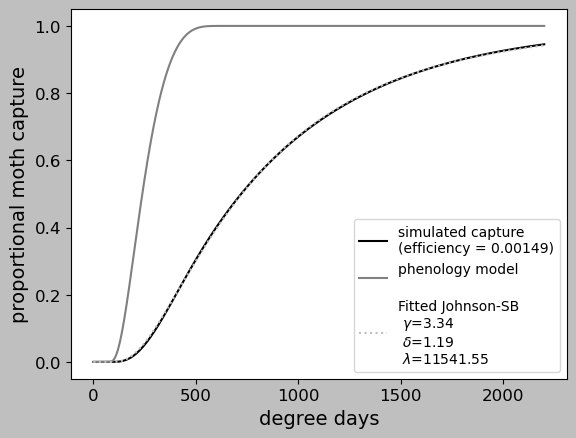

In [6]:
n = 10
x_opt = np.arange(0,dfs[n].dd.max()+1,1)
y_opt = dfs[n].pop_captured_0 / 1000
loc = 69
f = lambda dd, gamma, delta, llambda: johnsonsb.cdf(dd, gamma, delta, loc=loc, scale=llambda)
#[-4.8689+(0.3*n),2.0689+(0.06*n),27.503-(7*n),72.3-(3.75*n)]
gamma, delta, llambda = spop.curve_fit(f,x_opt,y_opt,p0=[1.07,1.2349,  577])[0]
y_pred = johnsonsb.cdf(x_opt,gamma, delta, loc=loc, scale=llambda)
effort = dfs[n].head(1).prob_capture.item()
sns.lineplot(x=x_opt, y=y_opt, label=f'simulated capture\n(efficiency = {round(effort,5)})', color='black')
sns.lineplot(x=x_opt, y=dfs[n].pop_emerged_0/1000, label='phenology model\n', color='grey')
sns.lineplot(x=x_opt, y=y_pred, label=f'Fitted Johnson-SB\n $\\gamma$={round(gamma,2)}\n $\\delta$={round(delta,2)}\n $\\lambda$={round(llambda,2)}', linestyle=':',color='silver')
plt.xlabel('degree days')
plt.ylabel('proportional moth capture')
gamma, delta, llambda

#### fit for all efficacies

In [7]:
f = lambda dd, gamma, delta, llambda: johnsonsb.cdf(dd, gamma, delta, loc=69, scale=llambda)
params = []
for n in range(1000):
    x_opt = np.arange(0,dfs[n].dd.max()+1,1)
    y_opt = dfs[n].pop_captured_0 / 1000
    effort = dfs[n].head(1).prob_capture.item()
    gamma, delta, llambda = spop.curve_fit(f,x_opt,y_opt,p0=[1.07,1.2349,  577])[0]
    params.append((gamma, delta, llambda, effort))

params = np.array(params).T
gammas = params[0]
deltas = params[1]
lambdas = params[2]
efforts = params[3]

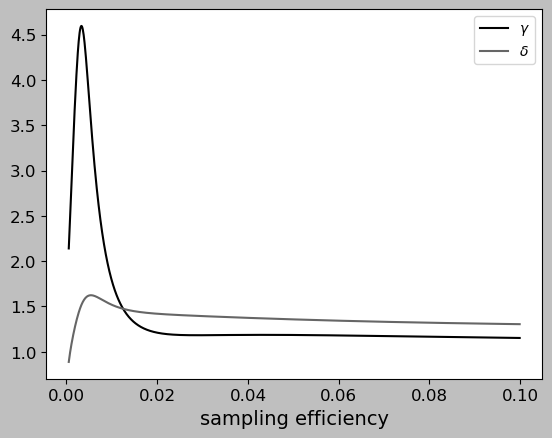

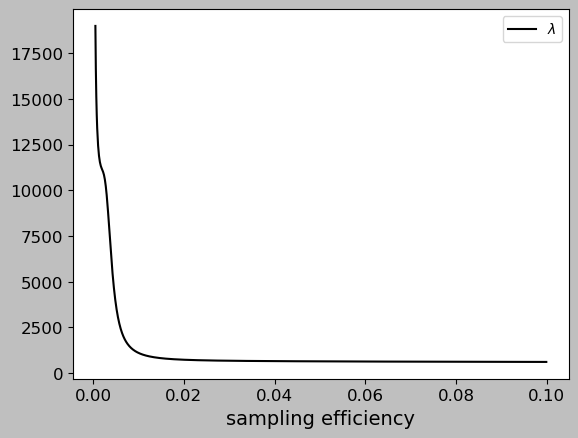

In [8]:
plt.xlabel('sampling efficiency')
sns.lineplot(x=efforts,y=gammas, label='$\\gamma$')
sns.lineplot(x=efforts,y=deltas, label='$\\delta$')
plt.figure()
plt.xlabel('sampling efficiency')
plt.plot(efforts,lambdas, label='$\\lambda$')
plt.legend()

126265237.76983745 736231.2641896334 13332.190899449635 334.6602590581555 1.6984373665201251 120412899.76863205 -923996.3302079471 65919.64074765948 -317.11049031421373
1.0624035915007024
[3.43752166e+06 1.30762665e+05 1.08819652e+03 8.11935763e+00
 3.21488255e-03 2.96210700e+06 1.08728766e+05 6.66639680e+02
 2.16245222e+00]


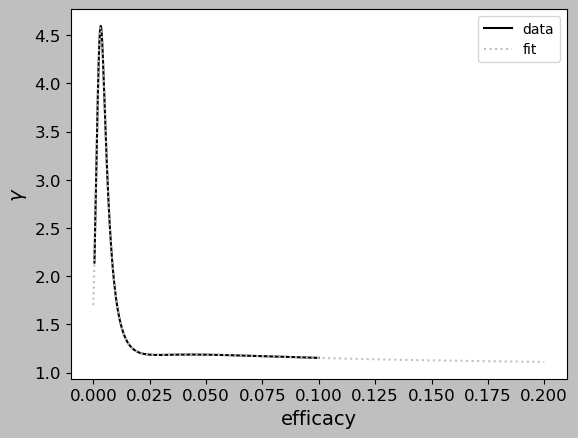

In [9]:
def rational(x, p, q):
    return np.polyval(p, x) / np.polyval(q + [1.0], x)
def rationaln_n(x, p0, p1, p2, p3, p4, q1, q2, q3, q4):
    return rational(x, [p0, p1, p2, p3, p4], [q1, q2, q3, q4])
effortspaced = np.linspace(0,0.2,5000)

popt_gammas, pcov_gammas = spop.curve_fit(rationaln_n, efforts, gammas)
plt.plot(efforts, gammas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_gammas), label='fit', linestyle=':', color='silver')
plt.legend()
plt.xlabel('efficacy')
plt.ylabel('$\\gamma$')
print(*popt_gammas)
(print(rationaln_n(1, *popt_gammas)))
print(np.sqrt(np.diag(pcov_gammas)))

202079477.73829928 7736443.383716124 -34507.41036917526 437.6416840243099 0.7130535227381546 168915277.1827922 4317629.410641449 -1402.6813619657487 64.43353361437673
1.2109908884324596
[1.68179153e+06 1.77181802e+05 1.30099893e+03 4.69460559e+00
 1.19701309e-03 1.34721046e+06 1.26037152e+05 9.49443760e+02
 3.09118519e+00]


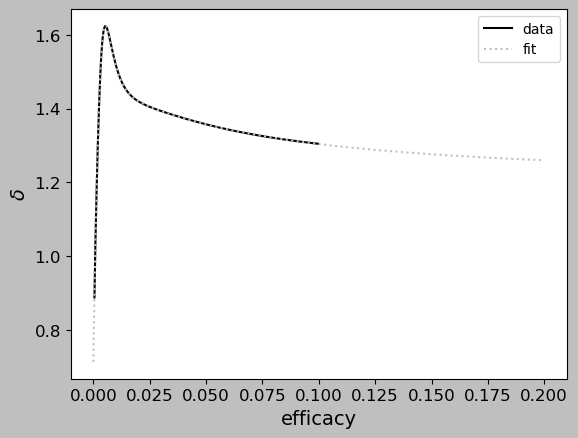

In [10]:
popt_deltas, pcov_deltas = spop.curve_fit(rationaln_n, efforts, deltas)

plt.plot(efforts, deltas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_deltas), label='fit', linestyle=':',color='silver')
plt.legend()
plt.xlabel('efficacy')
plt.ylabel('$\\delta$')
print(*popt_deltas)
(print(rationaln_n(1, *popt_deltas)))
print(np.sqrt(np.diag(pcov_deltas)))

0.44119839572540487
1.14937952758045
35.11032036879221
0.0022809516784330335
0.0011045152618119186
[7.91980108e-03 2.34615286e-03 1.42410521e-01 5.00414560e-06
 3.40697815e-06]


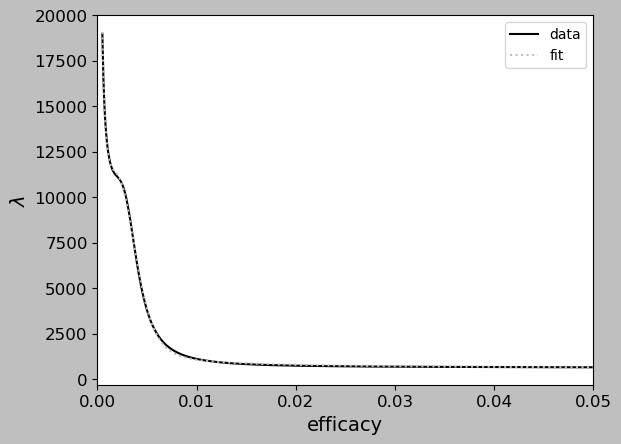

In [11]:
f_lambda = lambda x, b_0, b_1, b_2, b_3, b_4: np.reciprocal(b_0 * (x ** b_1)) + 577 + (b_2 * logistic.pdf(x, loc=b_3, scale=b_4)) 
effortspaced_lambda = np.linspace(0.0005,0.1,5000)
popt_lambdas, pcov_lambdas = spop.curve_fit(f_lambda, efforts, lambdas, p0=[2.5, 1.5, 40, 0.00225, 0.0013])
#popt_lambdas = [2.5, 1.5, 5000, 0.0025, 0.0013]
plt.plot(efforts, lambdas, label='data')
plt.plot(effortspaced_lambda, f_lambda(effortspaced_lambda, *popt_lambdas), label='fit', linestyle=':',color='silver')
plt.legend()
plt.xlabel('efficacy')
plt.ylabel('$\\lambda$')
plt.xlim(0,0.05)
for coef in popt_lambdas:
    print(coef)
print(np.sqrt(np.diag(pcov_lambdas)))

#### function from efficacy to SB curve

In [12]:
def capture_prediction_sb(dd, effort, max, print_coef=False):
    gamma = rationaln_n(effort, *popt_gammas)
    delta = rationaln_n(effort, *popt_deltas)
    llambda = f_lambda(effort, *popt_lambdas)
    xi = 69
    if print_coef:
        print(f'{gamma}, {delta}, {llambda}')
    return max * johnsonsb.cdf(dd, gamma, delta, loc=xi, scale=llambda)
def jw_emergence(dd, max):
    gamma = 1.0737
    delta = 1.2349
    llambda = 577.2
    zeta = 69.0
    return max * johnsonsb.cdf(dd, gamma, delta, loc=zeta, scale=llambda)

0.00249

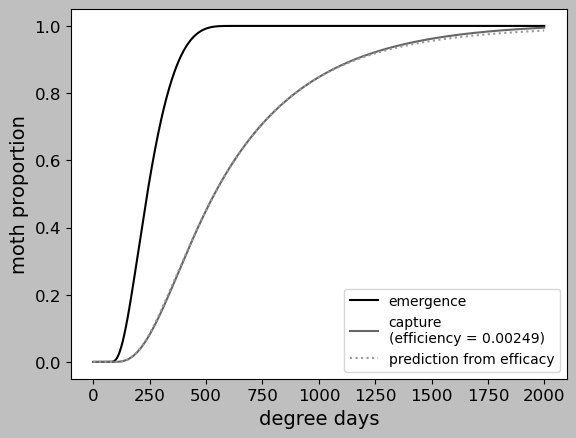

In [13]:
shift_data = dfs[20]
x = shift_data.dd
y_emerge = shift_data.pop_emerged_0
y_capture = shift_data.pop_captured_0
effort = shift_data.head(1).prob_capture.item()
max_time = 2000

y_max = y_capture.max()
func_adj_y = capture_prediction_sb(x, effort, 1000)
ax = sns.lineplot(x=x[0:max_time], y=y_emerge[0:max_time]/1000, label='emergence')
ax = sns.lineplot(x=x[0:max_time], y=y_capture[0:max_time]/np.max(y_capture), label=f'capture\n(efficiency = {round(effort,5)})')
ax = sns.lineplot(x=x[0:max_time], y=func_adj_y[0:max_time]/1000, label='prediction from efficacy', linestyle=':')
ax.set(xlabel='degree days', ylabel='moth proportion')
effort

### Test forecasting

In [14]:
def capture_prediction_sb(dd, effort, max=1, print_coef=False, xi=69):
    gamma = rationaln_n(effort, *popt_gammas)
    delta = rationaln_n(effort, *popt_deltas)
    llambda = f_lambda(effort, *popt_lambdas)
    dd = dd  - (xi-69)
    if print_coef:
        print(f'{gamma}, {delta}, {llambda}')
    return max * johnsonsb.cdf(dd, gamma, delta, loc=69, scale=llambda)
def predict_from_full(dds, captures, CI=False, xi=69):
    dds = dds - (xi-69)
    f = lambda dd, effort: capture_prediction_sb(dd, effort, np.max(captures))
    params, pcov = spop.curve_fit(f,dds,captures,p0=[0.005])
    effort = params[0]
    if CI:
        n = len(dds)
        dof = np.max((0,n - 2))
        tval = -t.ppf(0.95/2,dof)
        S = np.sqrt(np.diag(pcov))
        effort_CI = (effort - S[0]*tval, effort + S[0]*tval)
        return (effort, effort_CI)
    return effort

In [15]:
phenology_x = np.linspace(0,800, 100)
fieldnames = ['AllrCoug','CRO','fiveEa','Hansen','HoskGibOth','Royal','ValKoe']
filenames = [field+year for year in ['2018A','2019A','2020A','2021A'] for field in fieldnames]
def mae(filename, plot=False, ddlim=685, xi=69, residuals=False, efficacies = None):
    data = pd.read_csv('verification_data/'+filename+'.csv').dropna()
    data = data[data.iloc[:,4]<ddlim]
    dds = data.iloc[:,4]
    prop = data.iloc[:,5].cumsum()
    max_eff = predict_from_full(dds, prop, xi=xi)
    if efficacies == []:
        data = data[data.iloc[:,4]<300]
        dds = data.iloc[:,4]
        prop = data.iloc[:,5].cumsum()
        efficacy = max_eff
    elif efficacies == None:
        efficacy = max_eff
    else:
        efficacy = np.mean(efficacies)
    y_hat = capture_prediction_sb(dds, efficacy, xi=xi)
    meanae = np.mean(np.abs(y_hat - prop))
    if plot:
        sns.lineplot(x=dds, y=prop, label='observations')
        sns.lineplot(x=np.linspace(0,685, 100)+(xi-69), \
                     y=[jw_emergence(x, 1) for x in phenology_x], \
                     label='emergence model')
        sns.lineplot(x=dds, y=y_hat, label='model')
    if residuals:
        return (meanae.round(5), efficacy.round(5), max_eff, y_hat - prop)
    return (meanae.round(5), efficacy.round(5), max_eff.round(5))
def mae_oksir(n, plot=False, ddlim=685, xi=69, residuals=False, errorlim=685, efficacies = None):
    dds = aggs[n].DDs
    captures = aggs[n].moth_sum
    dds = dds[dds < ddlim]
    captures = captures[:len(dds)]
    prop = captures / captures.max()
    max_eff = predict_from_full(dds, prop, xi=xi)
    if efficacies == []:
        dds = dds[dds < 300]
        captures = captures[:len(dds)]
        prop = prop[:len(dds)]
        efficacy = max_eff
    elif efficacies == None:
        efficacy = max_eff
    else:
        efficacy = np.mean(efficacies)
    y_hat = capture_prediction_sb(dds, efficacy, xi=xi)
    meanae = np.mean(np.abs(y_hat - prop))
    if plot:
        sns.lineplot(x=dds, y=prop, label='observations')
        sns.lineplot(x=np.linspace(0,685, 100)+(xi-69), \
                     y=[jw_emergence(x, 1) for x in phenology_x], \
                     label='emergence model')
        sns.lineplot(x=dds, y=y_hat, label='model')
    if residuals:
        return (meanae.round(5), efficacy.round(5), y_hat - prop)
    return (meanae.round(5), efficacy.round(5), max_eff.round(5))

(0.14231, 0.008, 501851.16721)

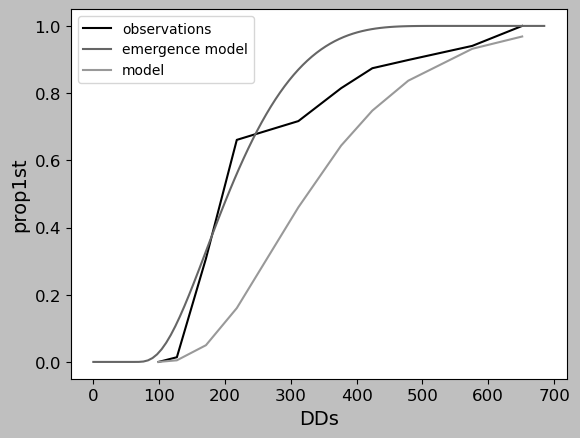

In [16]:
mae('CRO2020A', efficacies=[0.008],plot=True)

#### 4yr

In [17]:
results_4yr_adj_jwxi = pd.DataFrame(columns=['name','mae','test_efficacy','best_efficacy'])
for i, filename in enumerate(filenames):
    if (i % 4) == 0:
        efficacies = []
    score, eff, max_eff = mae(filename, efficacies = efficacies)
    results_4yr_adj_jwxi.loc[i] = (filename, score, eff, max_eff)
    if max_eff < 1:
        efficacies.append(max_eff)
results_4yr_adj_jwxi = results_4yr_adj_jwxi.sort_values('name')

In [18]:
print(results_4yr_adj_jwxi)
results_4yr_adj_jwxi_mean = np.mean(list(results_4yr_adj_jwxi.mae))
results_4yr_adj_jwxi_mean

               name      mae  test_efficacy  best_efficacy
0     AllrCoug2018A  0.03330        0.09988        0.09988
7     AllrCoug2019A  0.16718        0.00573    37638.27742
14    AllrCoug2020A  0.01802        0.01577        0.01761
21    AllrCoug2021A  0.07898        0.00654        0.00919
1          CRO2018A  0.12801        0.09988        0.00791
8          CRO2019A  0.06516        0.06382        0.06382
15         CRO2020A  0.11939        0.01638   501851.16721
22         CRO2021A  0.04223        0.00786        0.00940
3       Hansen2018A  0.20841        0.03782        0.00539
10      Hansen2019A  0.12338        0.03502        0.00601
17      Hansen2020A  0.09285        0.00691        0.00508
24      Hansen2021A  0.07190        0.00969        0.00969
4   HoskGibOth2018A  0.03213        0.00551        0.00551
11  HoskGibOth2019A  0.12494        0.02535        0.00563
18  HoskGibOth2020A  0.11632        0.00600        0.02323
25  HoskGibOth2021A  0.13617        0.00969        0.008

0.09346214285714284

In [19]:
# remove the AllrCoug2019 and CRO2020 data, as they're obviously just bad data
results_4yr_adj_jwxi_clean = results_4yr_adj_jwxi[results_4yr_adj_jwxi['best_efficacy'] < 1]

#### oksir

In [20]:
results_oksir_adj_jwxi = pd.DataFrame(columns=['name','mae','test efficacy','best efficacy'])
efficacies = []
for i, agg in enumerate(aggs):
    score, eff, max_eff = mae_oksir(i, efficacies = efficacies)
    results_oksir_adj_jwxi.loc[i] = (agg.year.head(1).item(), score, eff, max_eff)

In [21]:
print(results_oksir_adj_jwxi)
results_oksir_adj_jwxi_mean = np.mean(list(results_oksir_adj_jwxi.mae))
results_oksir_adj_jwxi_mean

      name      mae  test efficacy  best efficacy
0   1995.0  0.04501        0.01193        0.01193
1   1996.0  0.08920        0.00576        0.00576
2   1997.0  0.05808        0.00588        0.00588
3   1998.0  0.05244        0.00689        0.00689
4   1999.0  0.06261        0.01490        0.01490
5   2000.0  0.02450        0.00583        0.00583
6   2001.0  0.03199        0.00671        0.00671
7   2002.0  0.09643        0.00689        0.00689
8   2004.0  0.12652        0.00613        0.00613
9   2005.0  0.21092        0.00474        0.00474
10  2006.0  0.02350        0.00528        0.00528
11  2007.0  0.06404        0.00552        0.00552
12  2008.0  0.03506        0.00586        0.00586
13  2009.0  0.03740        0.00426        0.00426
14  2010.0  0.05017        0.00685        0.00685
15  2011.0  0.04265        0.00592        0.00592
16  2012.0  0.08587        0.00441        0.00441
17  2013.0  0.06221        0.00422        0.00422
18  2014.0  0.04025        0.00606        0.00606


0.06685250000000001

#### all

In [22]:
results_all_adj_jwxi = np.append( \
    np.array(list(results_4yr_adj_jwxi_clean.mae)),\
    np.array(list(results_oksir_adj_jwxi.mae))\
)
results_all_adj_jwxi_mean = np.mean(results_all_adj_jwxi)
results_all_adj_jwxi_mean, np.min(results_all_adj_jwxi), np.max(results_all_adj_jwxi)

(0.07972652173913043, 0.01802, 0.21092)

### Absolute trapping efficacy

#### location parameter optimization

In [23]:
filenames = np.sort(filenames)
allr = filenames[0:4]
cro = filenames[4:8]
hansen = filenames[8:12]
hosk = filenames[12:16]
royal = filenames[16:20]
val = filenames[20:24]
five = filenames[24:28]

# Remove years with highly non-JSB distribution or poor data quality
# to prevent them from polluting the measurements with such low sample sizes
allr = np.delete(allr,1)
cro = np.delete(cro,2)
hansen = np.delete(hansen,3)
hosk = np.delete(hosk,3)
five = np.delete(five,2)

In [24]:
def mse(filename, plot=False, ddlim=685, xi=69, residuals=False):
    data = pd.read_csv('verification_data/'+filename+'.csv').dropna()
    data = data[data.iloc[:,4]<ddlim]
    dds = data.iloc[:,4]
    prop = data.iloc[:,5].cumsum()
    max_eff = predict_from_full(dds, prop, xi=xi)
    y_hat = capture_prediction_sb(dds, max_eff, xi=xi)
    meanse = np.mean((y_hat - prop)**2)
    if plot:
        sns.lineplot(x=dds, y=prop, label='observations')
        sns.lineplot(x=np.linspace(0,685, 100)+(xi-69), \
                     y=[jw_emergence(x, 1) for x in phenology_x], \
                     label='emergence model')
        sns.lineplot(x=dds, y=y_hat, label='model')
    if residuals:
        return (meanse.round(5), max_eff.round(5), y_hat - prop)
    return (meanse.round(5), max_eff.round(5))
def mse_oksir(n, plot=False, ddlim=685, xi=69, residuals=False, errorlim=685, efficacies = None):
    dds = aggs[n].DDs
    captures = aggs[n].moth_sum
    dds = dds[dds < ddlim]
    captures = captures[:len(dds)]
    prop = captures / captures.max()
    max_eff = predict_from_full(dds, prop, xi=xi)
    y_hat = capture_prediction_sb(dds, max_eff, xi=xi)
    meanse = np.mean((y_hat - prop)**2)
    if plot:
        sns.lineplot(x=dds, y=prop, label='observations')
        sns.lineplot(x=np.linspace(0,685, 100)+(xi-69), \
                     y=[jw_emergence(x, 1) for x in phenology_x], \
                     label='emergence model')
        sns.lineplot(x=dds, y=y_hat, label='model')
    if residuals:
        return (meanse.round(5), max_eff.round(5), y_hat - prop)
    return (meanse.round(5), max_eff.round(5))

In [25]:
#AllrCoug
warnings.filterwarnings('ignore')
smse_allr = [np.sum(np.array([mse(file, xi=xi) for file in allr]).T[0]) for xi in range(10,150)]
warnings.filterwarnings('default')
allr_loc = np.argmin(smse_allr)+10
np.min(smse_allr), allr_loc, \
np.mean([mae(file,xi=allr_loc) for file in allr]).round(5)

(0.00706, 54, 0.02703)

In [26]:
#CRO
warnings.filterwarnings('ignore')
smse_cro = [np.sum(np.array([mse(file, xi=xi) for file in cro]).T[0]) for xi in range(10,150)]
warnings.filterwarnings('default')
cro_loc = np.argmin(smse_cro)+10
np.min(smse_cro), cro_loc, \
np.mean([mae(file,xi=cro_loc) for file in cro]).round(5)

(0.010159999999999999, 37, 0.02339)

In [27]:
#Hansen
warnings.filterwarnings('ignore')
smse_hansen = [np.sum(np.array([mse(file, xi=xi) for file in hansen]).T[0]) for xi in range(10,150)]
warnings.filterwarnings('default')
hansen_loc = np.argmin(smse_hansen)+10
np.min(smse_hansen), hansen_loc, \
np.mean([mae(file,xi=hansen_loc) for file in hansen]).round(5)

(0.01163, 149, 0.02194)

In [28]:
#Hosk
warnings.filterwarnings('ignore')
smse_hosk = [np.sum(np.array([mse(file, xi=xi) for file in hosk]).T[0]) for xi in range(10,150)]
warnings.filterwarnings('default')
hosk_loc = np.argmin(smse_hosk)+10
np.min(smse_hosk), hosk_loc, \
np.mean([mae(file,xi=hosk_loc) for file in hosk]).round(5)

(0.01259, 110, 0.03354)

In [29]:
#Royal
warnings.filterwarnings('ignore')
smse_royal = [np.sum(np.array([mse(file, xi=xi) for file in royal]).T[0]) for xi in range(10,150)]
warnings.filterwarnings('default')
royal_loc = np.argmin(smse_royal)+10
np.min(smse_royal), royal_loc, \
np.mean([mae(file,xi=royal_loc) for file in royal]).round(5)

(0.01339, 138, 0.02482)

In [30]:
#Val
warnings.filterwarnings('ignore')
smse_val = [np.sum(np.array([mse(file, xi=xi) for file in val]).T[0]) for xi in range(10,150)]
warnings.filterwarnings('default')
val_loc = np.argmin(smse_val)+10
np.min(smse_val), val_loc, \
np.mean([mae(file,xi=val_loc) for file in val]).round(5)

(0.015260000000000001, 82, 0.03337)

In [31]:
#Five
warnings.filterwarnings('ignore')
smse_five = [np.sum(np.array([mse(file, xi=xi) for file in five]).T[0]) for xi in range(10,120)]
warnings.filterwarnings('default')
five_loc = np.argmin(smse_five)+10
np.min(smse_five), five_loc, \
np.mean([mae(file,xi=five_loc) for file in five]).round(5)

(0.00928, 57, 0.01841)

In [32]:
def location_plot_file(filename, ax, ddlim=685, xi=69):
    data = pd.read_csv('verification_data/'+filename+'.csv').dropna()
    data = data[data.iloc[:,4]<ddlim]
    dds = data.iloc[:,4]
    prop = data.iloc[:,5].cumsum()
    efficacy = predict_from_full(dds, prop, xi=xi)
    y_hat = capture_prediction_sb(dds, efficacy, xi=xi)
    #meanae = np.mean(np.abs(y_hat - prop))
    limidx = np.argmax(dds>ddlim)
    meanae = np.mean(np.abs(y_hat[0:limidx-1,] - prop[0:limidx-1,]))
    sns.lineplot(x=dds, y=prop, label='observations', ax=ax, linestyle='-.')
    sns.lineplot(x=np.linspace(0,685, 100)+(xi-69), \
                      y=[jw_emergence(x, 1) for x in np.linspace(0,685, 100)], \
                      label=f'phenology \n(location = {xi})', ax=ax)
    sns.lineplot(x=dds, y=y_hat, label=f'model \n(efficacy = \n {efficacy.round(5)}\nMAE=\n{meanae.round(5)})', ax=ax, linestyle=':')
    ax.set_title(f'{filename}')
    ax.set_xlabel('CDD')
    ax.set_ylabel('moths')
    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[2:3], labels[2:3])

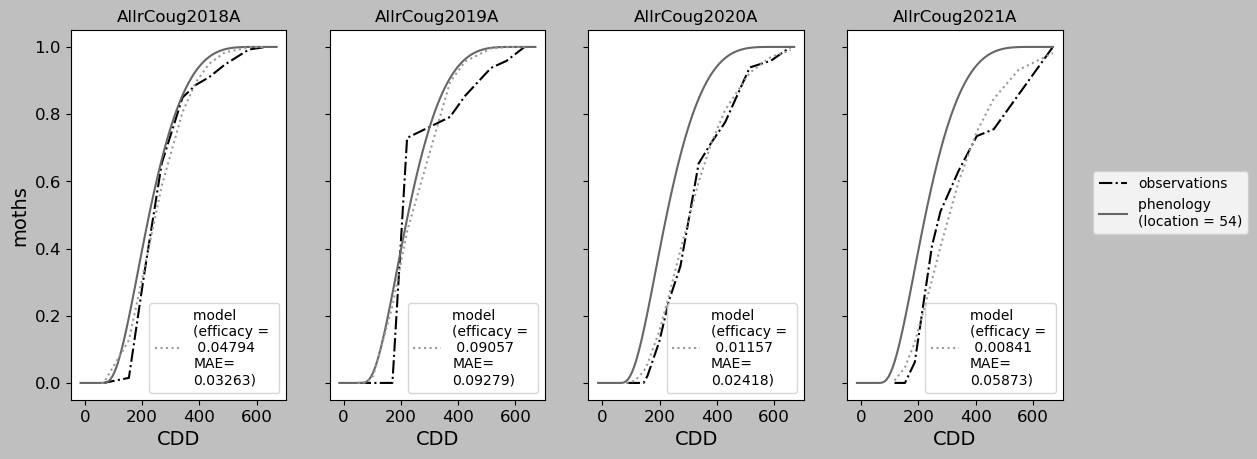

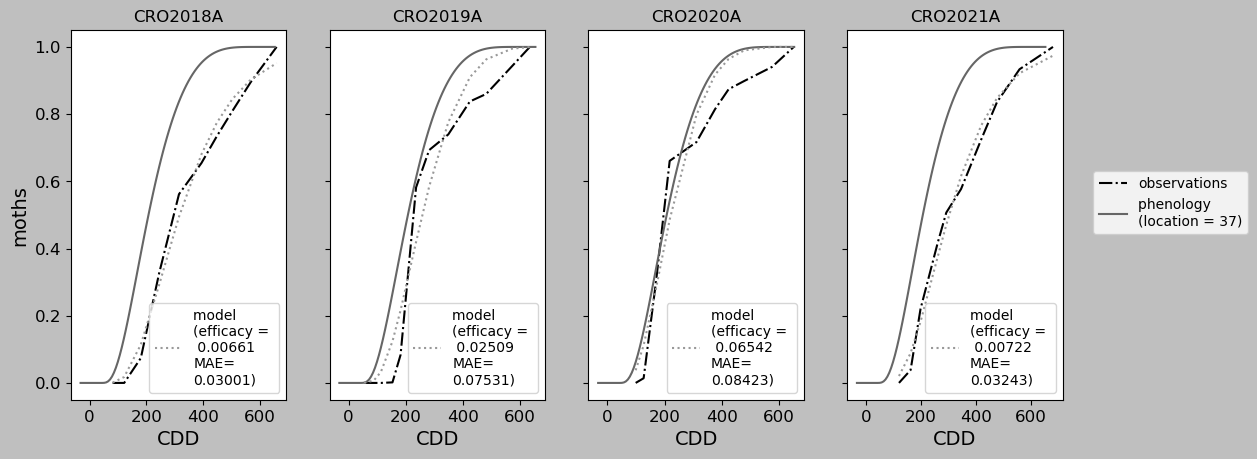

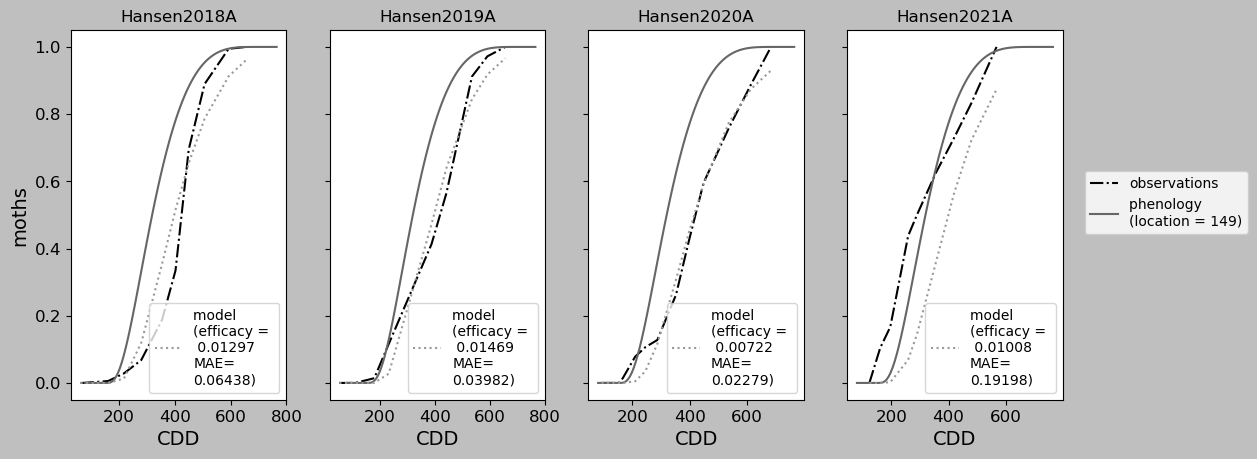

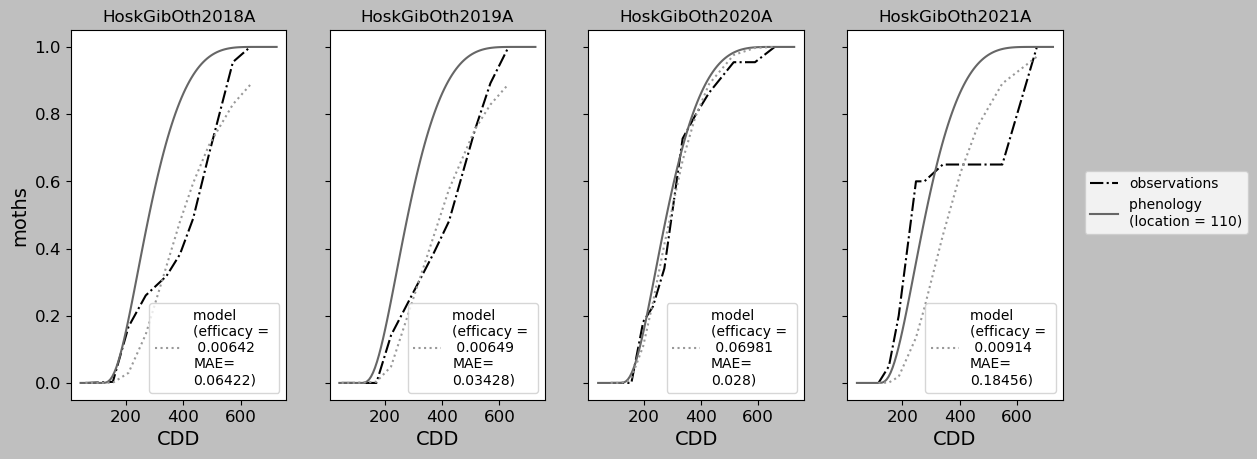

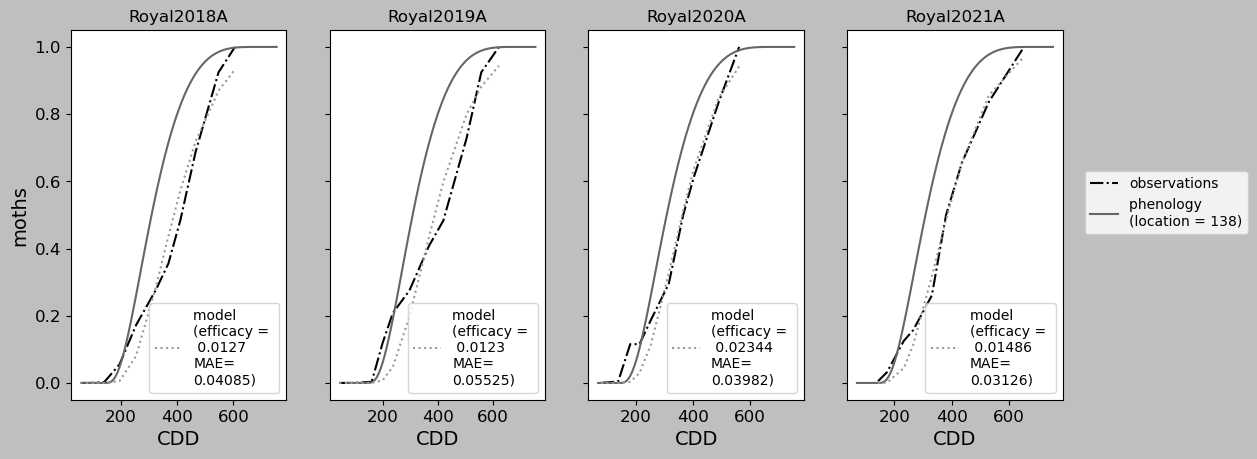

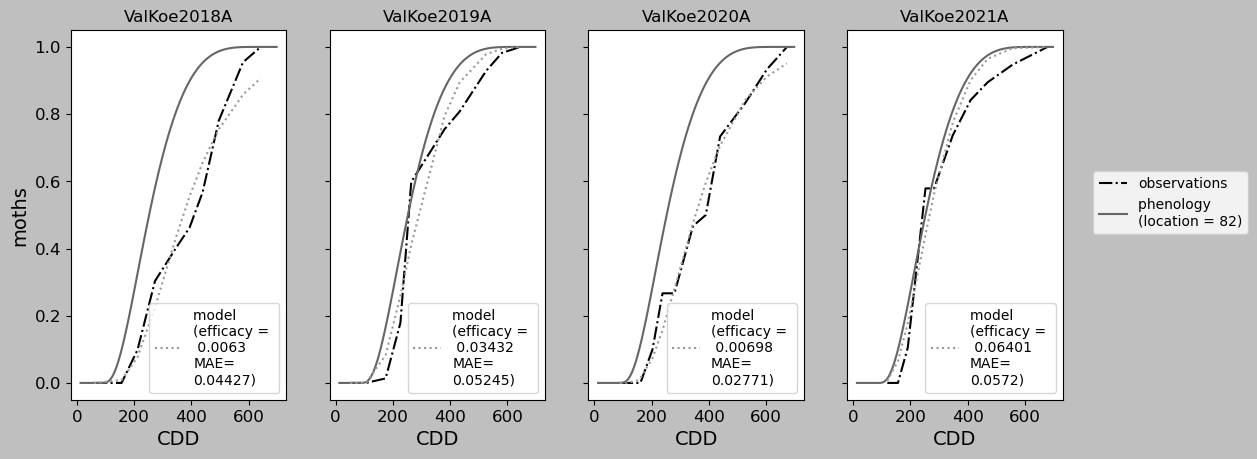

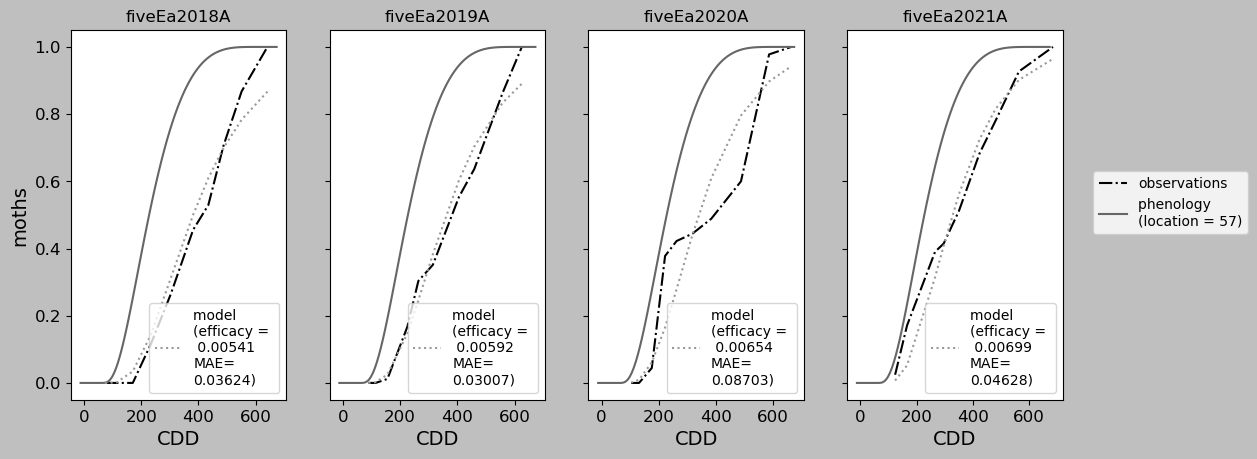

In [33]:
warnings.filterwarnings('ignore')
def facet_results_files(dset,loc):
    fig = plt.figure()
    axes = fig.subplots(1, len(dset), sharey=True)
    for i, file in enumerate(dset):
        location_plot_file(file, axes[i], ddlim=685, xi=loc)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels[0:2], bbox_to_anchor=(1.05, 0.6))
    fig_width, fig_height = plt.gcf().get_size_inches()
    plt.gcf().set_size_inches(fig_width*2, fig_height)

filenames = np.sort(filenames)
allr = filenames[0:4]
cro = filenames[4:8]
hansen = filenames[8:12]
hosk = filenames[12:16]
royal = filenames[16:20]
val = filenames[20:24]
five = filenames[24:28]
facet_results_files(allr,54)
facet_results_files(cro,37)
facet_results_files(hansen,149)
facet_results_files(hosk,110)
facet_results_files(royal,138)
facet_results_files(val, 82)
facet_results_files(five,57)

In [34]:
locs = [54,37,149,110,138,82,57]

In [35]:
# OKSIR
smse = [np.sum(np.array([mse_oksir(i, xi=xi) for i in range(len(aggs))]).T[0]) for xi in range(50,170)]
np.min(smse), np.argmin(smse)+50

(0.062240000000000004, 139)

#### 4yr

In [36]:
results_4yr_adj_newxi = pd.DataFrame(columns=['name','mae','test_efficacy','best_efficacy'])
for i, filename in enumerate(filenames):
    if (i % 4) == 0:
        efficacies = []
    score, eff, max_eff = mae(filename, efficacies = efficacies, xi=locs[math.floor(i/4)])
    results_4yr_adj_newxi.loc[i] = (filename, score, eff, max_eff)
    if max_eff < 1:
        efficacies.append(max_eff)
results_4yr_adj_newxi = results_4yr_adj_newxi.sort_values('name')

In [37]:
print(results_4yr_adj_newxi)
results_4yr_adj_newxi_mean = np.mean(list(results_4yr_adj_newxi.mae))
results_4yr_adj_newxi_mean

               name      mae  test_efficacy  best_efficacy
0     AllrCoug2018A  0.03829        0.04794        0.04794
1     AllrCoug2019A  0.07893        0.04794        0.09057
2     AllrCoug2020A  0.12720        0.06926        0.01157
3     AllrCoug2021A  0.12870        0.05003        0.00841
4          CRO2018A  0.02329        0.00661        0.00661
5          CRO2019A  0.09271        0.00661        0.02509
6          CRO2020A  0.08461        0.01585        0.06542
7          CRO2021A  0.12525        0.03237        0.00722
8       Hansen2018A  0.01438        0.01297        0.01297
9       Hansen2019A  0.03987        0.01297        0.01469
10      Hansen2020A  0.04088        0.01383        0.00722
11      Hansen2021A  0.18437        0.01163        0.01008
12  HoskGibOth2018A  0.05115        0.00642        0.00642
13  HoskGibOth2019A  0.04197        0.00642        0.00649
14  HoskGibOth2020A  0.14749        0.00646        0.06981
15  HoskGibOth2021A  0.16256        0.02757        0.009

0.07409607142857143

#### oksir

In [38]:
results_oksir_adj_newxi = pd.DataFrame(columns=['name','mae','test_efficacy','best_efficacy'])
efficacies = []
for i, agg in enumerate(aggs):
    score, eff, max_eff = mae_oksir(i, efficacies = efficacies, xi=139)
    results_oksir_adj_newxi.loc[i] = (agg.year.head(1).item(), score, eff, max_eff)

In [39]:
# remove the 1999 data, which becomes unstable with the location shift
results_oksir_adj_newxi_clean = results_oksir_adj_newxi[results_oksir_adj_newxi['best_efficacy'] < 1]

In [40]:
print(results_oksir_adj_newxi_clean)
results_oksir_adj_newxi_mean = np.mean(list(results_oksir_adj_newxi_clean.mae))
results_oksir_adj_newxi_mean

      name      mae  test_efficacy  best_efficacy
0   1995.0  0.02503        0.08291        0.08291
1   1996.0  0.01784        0.01528        0.01528
2   1997.0  0.01776        0.01330        0.01330
3   1998.0  0.00436        0.02542        0.02542
5   2000.0  0.06187        0.00906        0.00906
6   2001.0  0.01587        0.02772        0.02772
7   2002.0  0.02662        0.03211        0.03211
8   2004.0  0.03609        0.01615        0.01615
9   2005.0  0.12058        0.00629        0.00629
10  2006.0  0.05132        0.00692        0.00692
11  2007.0  0.01544        0.00796        0.00796
12  2008.0  0.01379        0.01342        0.01342
13  2009.0  0.00968        0.00589        0.00589
14  2010.0  0.04434        0.02900        0.02900
15  2011.0  0.04168        0.00908        0.00908
16  2012.0  0.02159        0.00601        0.00601
17  2013.0  0.02150        0.00583        0.00583
18  2014.0  0.05133        0.00954        0.00954
19  2015.0  0.04865        0.03399        0.03399


0.033965263157894734

#### all

In [41]:
results_all_adj_newxi = np.append( \
    np.array(list(results_4yr_adj_newxi.mae)),\
    np.array(list(results_oksir_adj_newxi_clean.mae))\
)
results_all_adj_newxi_mean = np.mean(results_all_adj_newxi)
results_all_adj_newxi_mean, np.min(results_all_adj_newxi), np.max(results_all_adj_newxi)

(0.05787297872340425, 0.00436, 0.18437)

### control group (no adjustment)

In [42]:
def mae_noadj(filename, ddlim=685):
    data = pd.read_csv('verification_data/'+filename+'.csv').dropna()
    data = data[data.iloc[:,4]<ddlim]
    dds = data.iloc[:,4]
    prop = data.iloc[:,5].cumsum()
    efficacy = predict_from_full(dds, prop)
    y_hat = capture_prediction_sb(dds, 1)
    meanae = np.mean(np.abs(y_hat - prop))  
    return meanae.round(5)
def mae_oksir_noadj(n, ddlim=685):
    dds = aggs[n].DDs
    captures = aggs[n].moth_sum
    dds = dds[dds < ddlim]
    captures = captures[:len(dds)]
    prop = captures / captures.max()
    efficacy = predict_from_full(dds, prop)
    y_hat = capture_prediction_sb(dds, 1)
    meanae = np.mean(np.abs(y_hat - prop))  
    return meanae.round(5)

#### 4yr

In [43]:
results_4yr_noadj = pd.DataFrame(columns=['name','mae'])
for i, filename in enumerate(filenames):
    score = mae_noadj(filename)
    results_4yr_noadj.loc[i] = (filename, score)

In [44]:
print(results_4yr_noadj)
results_4yr_noadj_mean = np.mean(list(results_4yr_noadj.mae))
results_4yr_noadj_mean

               name      mae
0     AllrCoug2018A  0.03178
1     AllrCoug2019A  0.07996
2     AllrCoug2020A  0.12171
3     AllrCoug2021A  0.13811
4          CRO2018A  0.13898
5          CRO2019A  0.07124
6          CRO2020A  0.07136
7          CRO2021A  0.13316
8       Hansen2018A  0.25208
9       Hansen2019A  0.16067
10      Hansen2020A  0.26235
11      Hansen2021A  0.13085
12  HoskGibOth2018A  0.23086
13  HoskGibOth2019A  0.18107
14  HoskGibOth2020A  0.10095
15  HoskGibOth2021A  0.14254
16       Royal2018A  0.23314
17       Royal2019A  0.19600
18       Royal2020A  0.21704
19       Royal2021A  0.27499
20      ValKoe2018A  0.20814
21      ValKoe2019A  0.07896
22      ValKoe2020A  0.18485
23      ValKoe2021A  0.08083
24      fiveEa2018A  0.23336
25      fiveEa2019A  0.19881
26      fiveEa2020A  0.16147
27      fiveEa2021A  0.15646


0.15970428571428572

#### oksir

In [45]:
results_oksir_noadj = pd.DataFrame(columns=['name','mae'])
for i, agg in enumerate(aggs):
    score = mae_oksir_noadj(i)
    results_oksir_noadj.loc[i] = (agg.year.head(1).item(), score)

In [46]:
print(results_oksir_noadj)
results_oksir_noadj_mean = np.mean(list(results_oksir_noadj.mae))
results_oksir_noadj_mean

      name      mae
0   1995.0  0.18205
1   1996.0  0.29896
2   1997.0  0.26851
3   1998.0  0.17935
4   1999.0  0.19120
5   2000.0  0.28711
6   2001.0  0.18513
7   2002.0  0.24834
8   2004.0  0.27025
9   2005.0  0.37282
10  2006.0  0.30965
11  2007.0  0.31377
12  2008.0  0.24951
13  2009.0  0.30049
14  2010.0  0.23643
15  2011.0  0.28231
16  2012.0  0.41193
17  2013.0  0.39556
18  2014.0  0.26788
19  2015.0  0.22649


0.27388699999999994

#### all

In [47]:
results_all_noadj = np.append( \
    np.array(list(results_4yr_noadj.mae)),\
    np.array(list(results_oksir_noadj.mae))\
)
results_all_noadj_mean = np.mean(results_all_noadj)
results_all_noadj_mean, np.min(results_all_noadj), np.max(results_all_noadj)

(0.20728041666666666, 0.03178, 0.41193)

### relationship between mean culumative captures and mean average error

#### adjusted

In [48]:
def cumavg_captures(file):
    data = pd.read_csv('verification_data/'+file+'.csv').dropna()
    total = data.iloc[:,3].cumsum().tail(1).item()
    traps = data.iloc[:,2].max()
    return total / traps
def cumavg_captures_oksir(n):
    data = aggs[n]
    total = data.iloc[:,3].cumsum().tail(1).item()
    traps = data.iloc[:,2].max()
    return total / traps
locations = {'AllrCoug':54,
            'CRO':37,
            'Hansen':149,
            'HoskGibOth':110,
            'Royal':138,
            'ValKoe':82,
            'fiveEa':57}
warnings.filterwarnings('ignore')
avgcaps_mae = np.array([(cumavg_captures(file[:-1]),mae(file, xi=locations[file[:-5]])[0]) for file in filenames]).T
maecaps = pd.DataFrame({'average_captures':avgcaps_mae[0],'MAE':avgcaps_mae[1]})
model_maecaps = smf.ols('np.log(MAE) ~ np.log(average_captures)', data=maecaps).fit()
model_maecaps_lin = smf.ols('MAE ~ average_captures', data=maecaps).fit()
#sns.lineplot(x=maecaps.average_captures, y=maecaps.MAE.rolling(2).agg('mean'), label='cumulative mean')
#sns.lineplot(x=maecaps.average_captures, y=maecaps.MAE.rolling(2).agg('var'), label='cumulative variance')
warnings.filterwarnings('default')
print(model_maecaps.summary())
print(model_maecaps_lin.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(MAE)   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.726
Date:                Wed, 19 Feb 2025   Prob (F-statistic):              0.111
Time:                        11:19:51   Log-Likelihood:                -18.968
No. Observations:                  28   AIC:                             41.94
Df Residuals:                      26   BIC:                             44.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### unadjusted

In [49]:
warnings.filterwarnings('ignore')
avgcaps_mae_noadj = np.array([(cumavg_captures(file[:-1]),mae_noadj(file)) for file in filenames]).T
maecaps_noadj = pd.DataFrame({'average_captures':avgcaps_mae_noadj[0],'MAE':avgcaps_mae_noadj[1]})
model_maecaps_noadj = smf.ols('np.log(MAE) ~ np.log(average_captures)', data=maecaps_noadj).fit()
model_maecaps_noadj_lin = smf.ols('MAE ~ average_captures', data=maecaps_noadj).fit()

warnings.filterwarnings('default')
print(model_maecaps_noadj.summary())
print(model_maecaps_noadj_lin.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(MAE)   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     7.304
Date:                Wed, 19 Feb 2025   Prob (F-statistic):             0.0120
Time:                        11:19:52   Log-Likelihood:                -16.684
No. Observations:                  28   AIC:                             37.37
Df Residuals:                      26   BIC:                             40.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### comparison plots

Text(0.73, 0.895, 'B')

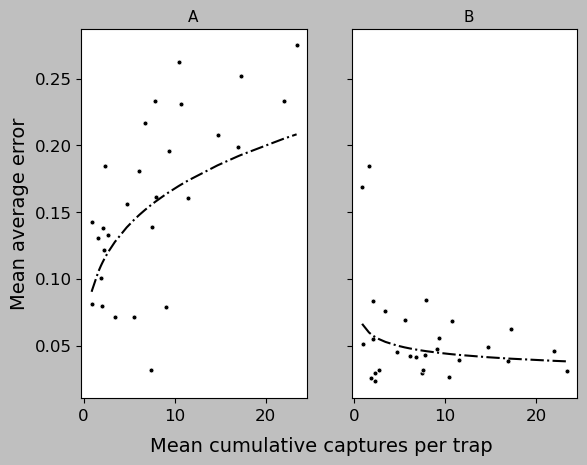

In [50]:
fig_maecaps = plt.figure()
axes_maecaps = fig_maecaps.subplots(1, 2, sharey=True)
sns.scatterplot(x=maecaps_noadj.average_captures, y=maecaps_noadj.MAE,s=50,marker=".", ax=axes_maecaps[0])
sns.lineplot(x=maecaps_noadj.average_captures, y=np.exp(model_maecaps_noadj.predict(maecaps_noadj.average_captures)),linestyle='-.', ax=axes_maecaps[0])
#sns.lineplot(x=maecaps_noadj.average_captures, y=model_maecaps_noadj_lin.predict(maecaps_noadj.average_captures),linestyle=':', ax=axes_maecaps[0])
axes_maecaps[0].set_xlabel('')
axes_maecaps[0].set_ylabel('Mean average error')
sns.scatterplot(x=maecaps.average_captures, y=maecaps.MAE,s=50,marker=".", ax=axes_maecaps[1])
sns.lineplot(x=maecaps.average_captures, y=np.exp(model_maecaps.predict(maecaps.average_captures)),linestyle='-.', ax=axes_maecaps[1])
#sns.lineplot(x=maecaps.average_captures, y=model_maecaps_lin.predict(maecaps.average_captures),linestyle=':', ax=axes_maecaps[1])
axes_maecaps[1].set_xlabel('')
fig_maecaps.text(0.5, 0, 'Mean cumulative captures per trap', ha='center',size=14)
fig_maecaps.text(0.3, 0.895, 'A', ha='center',size=11)
fig_maecaps.text(0.73, 0.895, 'B', ha='center',size=11)
#plt.savefig('./figures/finals/avgcumcaps.png',dpi=300,bbox_inches='tight')

In [51]:
lowsamples = {filename:(cumavg_captures(filename[:-1])>2.5) for filename in filenames}
lowsamples_oksir = {n:(cumavg_captures_oksir(n)>2.5) for n in range(len(aggs))}

In [61]:
lowsamples

{'AllrCoug2018A': True,
 'AllrCoug2019A': False,
 'AllrCoug2020A': False,
 'AllrCoug2021A': False,
 'CRO2018A': True,
 'CRO2019A': True,
 'CRO2020A': True,
 'CRO2021A': True,
 'Hansen2018A': True,
 'Hansen2019A': True,
 'Hansen2020A': True,
 'Hansen2021A': False,
 'HoskGibOth2018A': True,
 'HoskGibOth2019A': True,
 'HoskGibOth2020A': False,
 'HoskGibOth2021A': False,
 'Royal2018A': True,
 'Royal2019A': True,
 'Royal2020A': True,
 'Royal2021A': True,
 'ValKoe2018A': True,
 'ValKoe2019A': True,
 'ValKoe2020A': False,
 'ValKoe2021A': False,
 'fiveEa2018A': True,
 'fiveEa2019A': True,
 'fiveEa2020A': True,
 'fiveEa2021A': True}

In [52]:
filenames_clean = np.delete(filenames[np.array(list(lowsamples.values()))],[0,2,3,18])
#clean out the files with too few moths per trap or those with high error caused by non-Johnson-SB distribution
#also remove AllrCoug, because the other three are so high error that the location parameter estimation isn't reliable for the remaining fieldyear
filenames_clean

array(['CRO2018A', 'CRO2021A', 'Hansen2018A', 'Hansen2019A',
       'Hansen2020A', 'HoskGibOth2018A', 'HoskGibOth2019A', 'Royal2018A',
       'Royal2019A', 'Royal2020A', 'Royal2021A', 'ValKoe2018A',
       'ValKoe2019A', 'fiveEa2018A', 'fiveEa2019A', 'fiveEa2021A'],
      dtype='<U15')

#### relationship between trap density and absolute efficacy

(array([ 4.09646103e-01, -1.74371736e-02,  7.51993614e+01, -1.67191374e+01]),
 0.122)

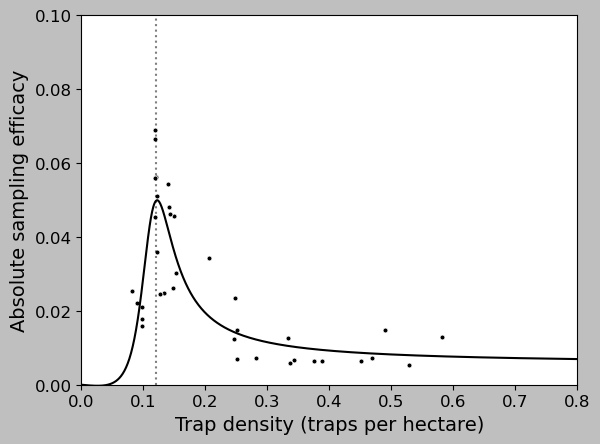

In [53]:
warnings.filterwarnings('ignore')
densities = pd.read_csv('verification_data/trap_densities.csv')
densities_oksir = pd.read_csv('verification_data/oksir_densities.csv')
plt.xlabel('Trap density (traps per hectare)')
plt.ylabel('Absolute sampling efficacy')
plt.xlim(0,0.6)
traps_eff_oksir = np.array([(\
                        densities_oksir.iloc[n].density.item(),\
                        mae_oksir(n, xi=139)[0]) \
                        for n in range(len(aggs))\
                      ])
traps_eff_4yr = np.array([(\
                        densities[densities.field_name==file].density.item(),\
                        mae(file, xi=locations[file[:-5]])[1]) \
                        for file in filenames_clean\
                      ])
traps_eff = np.append(traps_eff_oksir, traps_eff_4yr, axis=0).T
#traps_eff2 = np.append([[0,0]],traps_eff2,axis=0).T
dens_eff = pd.DataFrame({'density':traps_eff[0],'efficacy':traps_eff[1]})

def f_dens(x, p0, p1, q1, q2):
    return rational(x, [p0, p1, 0], [q1, q2])
popt_dens = spop.curve_fit(f_dens, dens_eff.density, dens_eff.efficacy)[0]

sns.scatterplot(x=dens_eff.density, y=dens_eff.efficacy,s=50,marker=".")
interp = np.linspace(0,1,1500)
sns.lineplot(x=interp, y=f_dens(interp,*popt_dens))
plt.axvline(0.12, linestyle=':', alpha=0.5)
plt.ylim(0,0.1)
plt.xlim(0,0.8)
#plt.savefig('./figures/finals/density_efficacy.png',dpi=300,bbox_inches='tight')
popt_dens, np.argmax(f_dens(interp,*popt_dens))*(1/1500)

In [54]:
(np.min(traps_eff[1]),\
np.mean(traps_eff[1]),\
np.max(traps_eff[1]))

(0.00541, 0.02682944444444445, 0.06882)